# NMF

In [1]:
# Add lemmatization
# Add coherence matrix (k by score: k = 1, Coherence score: 0.8242367870330447)
# And a graph of k by score (see 30-NMF-v2.ipynb)
# Check random state values to determine/justity a value for that input
# Don't print topics until the number of topics is chosen
# Run a final output with the chosen number of topics and random_state

In [2]:
import pandas as pd
import os
import csv
import nltk # If this step fails, rerun 07-Install-NLTK.ipynb
import string

# Identify the working directory and data files
working_directory = './31-NMF-with-Sentences'

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [3]:
# Read the preprocessed data into a dataframe
import pickle

with open('./21-Preprocess-Combined-Data-v2/dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

In [4]:
df.shape

(5736, 20)

In [5]:
df.head(1)

,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,UDI-DI,UDI-PUBLIC,DATE_OF_EVENT,REPORTER_OCCUPATION_CODE,REPORT_DATE,EVENT_LOCATION,SOURCE_TYPE,TOKENIZED_TEXT,NOPUNCT_TEXT,NOSTOPWORDS_TEXT,NODIGITS_TEXT,POS_TEXT,LEMMATIZED_TEXT,STEMMED_TEXT
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,,,07/30/2020,000,,I,CONSUMER,"[it, was, reported, that, the, transmitter, lo...","[it, was, reported, that, the, transmitter, lo...","[reported, transmitter, lost, connection, pump...","[reported, transmitter, lost, connection, pump...","[(reported, VBN), (transmitter, NN), (lost, VB...","[report, transmitter, lose, connection, pump, ...","[report, transmitt, lost, connect, pump, great..."


In [6]:
# Topics range
min_topics = 1
max_topics = 25

# The number of top words per topic
num_top_words = 10

# Initial random state
random_state = 42

# A row to use for verification of processing
verification_row = 9

In [7]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        'SENTENCE_ID',
        'SENTENCE', 
        'ROW_ID', 
        'FOI_TEXT', 
        'DEVICE_PROBLEM_CODE',
        'DEVICE_PROBLEM_TEXT'
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row['FOI_TEXT']):
        sentence_data = {
            'SENTENCE': sentence,
            'SENTENCE_ID': sentence_counter,
            'ROW_ID': row['ROW_ID'], 
            'FOI_TEXT': row['FOI_TEXT'], 
            'DEVICE_PROBLEM_CODE': row['DEVICE_PROBLEM_CODE'],
            'DEVICE_PROBLEM_TEXT': row['DEVICE_PROBLEM_TEXT']
        }
        sentences_df = sentences_df.append(sentence_data, ignore_index=True)
        sentence_counter = sentence_counter + 1        

In [8]:
sentences_df.shape

(25686, 5)

In [9]:
sentences_df.head(1)

,SENTENCE,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT
0,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem


In [10]:
# Process the sentences
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

punctuations = set(string.punctuation)

def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r'\b\d\w*\b', '', sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in sentence_tokens]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence_tokens]
    
    # Rebuild the sentence
    sentence = ' '.join(lemmatized_tokens)

    return sentence

sentences_df['PROCESSED_SENTENCE'] = sentences_df['SENTENCE'].apply(process_sentence)

In [11]:
print(f"'{sentences_df['SENTENCE'][verification_row]}' ==> '{sentences_df['PROCESSED_SENTENCE'][verification_row]}'")

'THE PROBABLE CAUSE COULD NOT BE DETERMINED.' ==> 'probable cause could determine'


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim import corpora

# Vectorize the sentences using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

vectorized_sentences = vectorizer.fit_transform(sentences_df['PROCESSED_SENTENCE'])

In [13]:
coherence_scores_df = pd.DataFrame(columns=['k', 'Coherence Score'])

for k in range(min_topics, max_topics + 1):
    nmf_model = NMF(
        n_components=k, 
        random_state=random_state, 
        init='nndsvda'
    )
    
    nmf = nmf_model.fit_transform(vectorized_sentences)
    
    vocab = vectorizer.get_feature_names_out()
    
    topics = []
    
    for topic_index, topic in enumerate(nmf_model.components_):
        top_words = [vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(top_words)
    
    # split each sentence into a list of words
    texts = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: nltk.word_tokenize(x)).tolist()
    
    # Create a dictionary from the words
    dictionary = corpora.Dictionary(texts)
    
    # Create a bag-of-words representation of the corpus
    corpus = [dictionary.doc2bow(word) for word in texts]
    
    coherence_model = CoherenceModel(
                        topics=topics, 
                        texts=texts, 
                        dictionary=dictionary, 
                        coherence='c_v'
                      )
    
    coherence_score = coherence_model.get_coherence()

    coherence_scores_df = coherence_scores_df.append(
        pd.Series(
            [k, coherence_score], 
            index=coherence_scores_df.columns
        ), 
        ignore_index=True
    )
    
coherence_scores_df

,k,Coherence Score
0,1.0,0.237714
1,2.0,0.295871
2,3.0,0.365870
3,4.0,0.353840
4,5.0,0.362692
5,6.0,0.394495
6,7.0,0.424196
7,8.0,0.420263
8,9.0,0.407765
9,10.0,0.396091


In [48]:
# save the coherence_scores_df code to a file as HTML
with open(f"{working_directory}/nmf_using_sentences_coherence_scores_table.html", 'w') as f:
    f.write(coherence_scores_df.to_html(index=False))

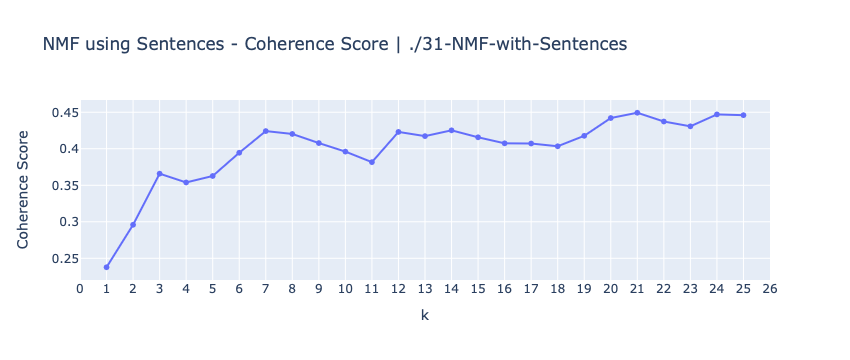

In [23]:
import plotly.express as px

fig_1 = px.line(
    coherence_scores_df, 
    x='k', 
    y='Coherence Score', 
    title=f"NMF using Sentences - Coherence Score | {working_directory}\n"
)

# add markers for each point
fig_1.update_traces(mode='lines+markers')

# extend the limits of the x-axis from 0 to 16
fig_1.update_xaxes(range=[0, max_topics + 1])

# show all numbers on the x-axis
fig_1.update_layout(xaxis=dict(tickmode='linear'))

# write the graph to a file in the working directory
fig_1.write_html(f"{working_directory}/nmf_using_sentences_coherence_scores_chart.html")

# show the plot
fig_1.show()

In [27]:
# Select the highest score

# Sort the dataframe by Coherence Score in descending order
sorted_df = coherence_scores_df.sort_values(by='Coherence Score', ascending=False)

# Pick the value of k from the first row of the sorted dataframe
selected_k = sorted_df.iloc[0]['k']

print(f"Highest Coherence Score: {selected_k} = {sorted_df.iloc[0]['Coherence Score']}")

Highest Coherence Score: 21.0 = 0.44929174084449947


In [44]:
# Create an NMF model using the selected k
nmf_model = NMF(
    n_components=int(selected_k),
    random_state=random_state, 
    init='nndsvda'
)
    
nmf = nmf_model.fit_transform(vectorized_sentences)

vocab = vectorizer.get_feature_names_out()

topics_df = pd.DataFrame(columns=['Topic', f"Top {num_top_words} Words"])

# get the topics and top words
for topic_index, topic in enumerate(nmf_model.components_):
    top_words = [vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    topics.append(top_words)
    selected_words = ", ".join([vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]])

    topics_df = topics_df.append(
        pd.Series(
            [topic_index + 1, selected_words], 
            index=topics_df.columns
        ), 
        ignore_index=True
    )

In [47]:
with pd.option_context('display.max_colwidth', None):
    display(topics_df)

,Topic,Top 10 Words
0,1,"injury, intervention, medical, report, alert, receive, adverse, impact, expiration, lose"
1,2,"probable, determine, cause, battery, low, data, transmitter, allegation, mobile, defective"
2,3,"hour, signal, loss, occur, report, greater, connection, application, lose, relate"
3,4,"confirm, allegation, data, undetermined, greater, message, addition, early, expiration, problem"
4,5,"provide, evaluation, data, product, receive, investigation, pending, supplemental, submit, reflect"
5,6,"fail, error, transmitter, occur, report, receive, customer, battery, low, alert"
6,7,"review, log, share, window, investigation, perform, loss, signal, connection, allege"
7,8,"additional, patient, event, available, information, close, mobile, misuse, app, reportable"
8,9,"evaluate, data, product, undetermined, receive, investigation, session, support, greater, message"
9,10,"supplemental, submit, relevant, new, available, information, report, receive, evaluation, perform"


In [49]:
# save the topics_df code to a file as HTML
with open(f"{working_directory}/nmf_using_sentences_topics_and_words_table.html", 'w') as f:
    f.write(topics_df.to_html(index=False))

In [36]:
# Write the sentences dataframe to a CSV file
sentences_df.to_csv(f"{working_directory}/sentences_dataframe.csv", index=False)

In [43]:
import os
import fnmatch
import subprocess

bucket = "praxis-2023-html-output"
website = f"http://{bucket}.s3-website-us-west-2.amazonaws.com"

# Use the fnmatch module to find all files in the current directory that end in ".html"
file_list = []
for root, dirnames, filenames in os.walk("."):
    for filename in fnmatch.filter(filenames, '*.html'):
        file_list.append(os.path.join(root, filename))

# Sort the file list alphabetically
file_list.sort()

# Create the HTML file and write the header
with open(os.path.join(".", 'index.html'), 'w') as f:
    f.write('''<html>
        <head>
            <title>Praxis 2023 HTML Output</title>
            <style>
                table {
                    border-collapse: collapse;
                    width: 100%;
                }
                th, td {
                    text-align: left;
                    padding: 8px;
                }
                th {
                    background-color: #007bff;
                    color: #fff;
                    font-weight: bold;
                }
                tr:nth-child(even) {
                    background-color: #f2f2f2;
                }
                tr:hover {
                    background-color: #ddd;
                }
            </style>
        </head>
        <body>
            <table>
                <tr><th>Name</th><th>Size</th></tr>\n
    ''')

    # Loop through each file and add a row to the table
    for file_name in file_list:
        if file_name in ['./index.html']:
            continue
            
        file_size = os.path.getsize(file_name)
        f.write(f'<tr><td><a href="{website}/{file_name}" target="_blank" rel="noopener noreferrer">{file_name}</a></td><td>{int(file_size / 1048576)} MB</td></tr>\n')

    # Write the footer and close the file
    f.write('</table></body></html>')

command = ["aws", "s3", "sync", ".", f"s3://{bucket}", "--exclude", "*", "--include", "*.html", "--no-progress"]

# Run the command and wait for it to complete
output = subprocess.run(command, capture_output=True, text=True)

# Print the output
print(output.stdout)
print('fin')

upload: 31-NMF-with-Sentences/.ipynb_checkpoints/nmf_using_sentences_coherence_scores_chart-checkpoint.html to s3://praxis-2023-html-output/31-NMF-with-Sentences/.ipynb_checkpoints/nmf_using_sentences_coherence_scores_chart-checkpoint.html
upload: 31-NMF-with-Sentences/.ipynb_checkpoints/nmf_using_sentences_topics_table-checkpoint.html to s3://praxis-2023-html-output/31-NMF-with-Sentences/.ipynb_checkpoints/nmf_using_sentences_topics_table-checkpoint.html
upload: 31-NMF-with-Sentences/nmf_using_sentences_coherence_scores_chart.html to s3://praxis-2023-html-output/31-NMF-with-Sentences/nmf_using_sentences_coherence_scores_chart.html
upload: 31-NMF-with-Sentences/nmf_using_sentences_topics_table.html to s3://praxis-2023-html-output/31-NMF-with-Sentences/nmf_using_sentences_topics_table.html
upload: ./index.html to s3://praxis-2023-html-output/index.html
upload: 31-NMF-with-Sentences/nmf_using_sentences_coherence_scores.html to s3://praxis-2023-html-output/31-NMF-with-Sentences/nmf_using_